# File and libraries

In [9]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_final"

# DSLabs functions

In [10]:
%run "scripts/dslabs_functions.py"


# Data functions

In [11]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [12]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    # data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    # train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 743351 entries, 0 to 743350
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   device_category                  743351 non-null  float64
 1   device_mobile_model_name         743351 non-null  float64
 2   device_operating_system          743351 non-null  float64
 3   device_operating_system_version  743351 non-null  float64
 4   device_language                  743351 non-null  float64
 5   device_web_info_browser          743351 non-null  float64
 6   device_web_info_browser_version  743351 non-null  float64
 7   geo_region                       743351 non-null  float64
 8   geo_city                         743351 non-null  float64
 9   traffic_source_medium            743351 non-null  float64
 10  traffic_source_source            743351 non-null  float64
 11  engagement_time_msec             743351 non-null  float64
 12  month  

# Distribution Check

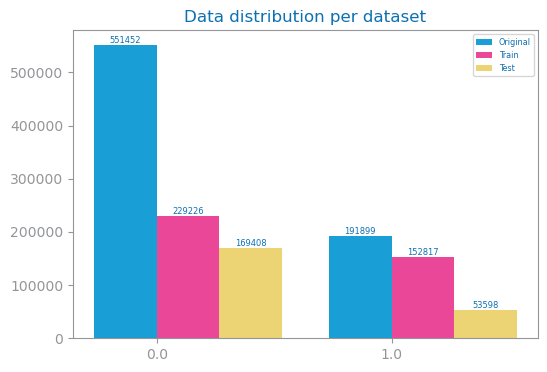

In [13]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [14]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=382043 Test#=223006
Labels=[0.0, 1.0]


## recall evaluation

DT best with entropy and d=2


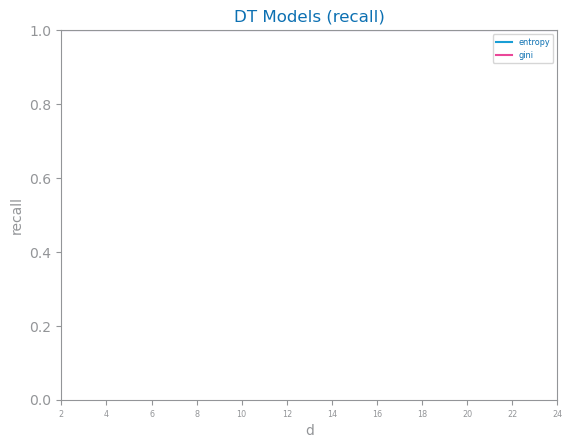

In [15]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='recall')
    savefig(f'images/{file_tag}_dt_recall_study.png')
    show()

## evaluate precision

DT best with entropy and d=2


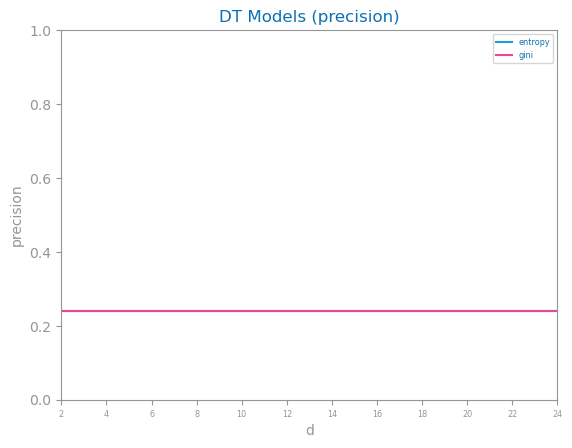

In [16]:
if evaluate==True:

    best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='precision')
    savefig(f'images/{file_tag}_dt_precision_study.png')
    show()

## evaluate accuracy

DT best with entropy and d=2


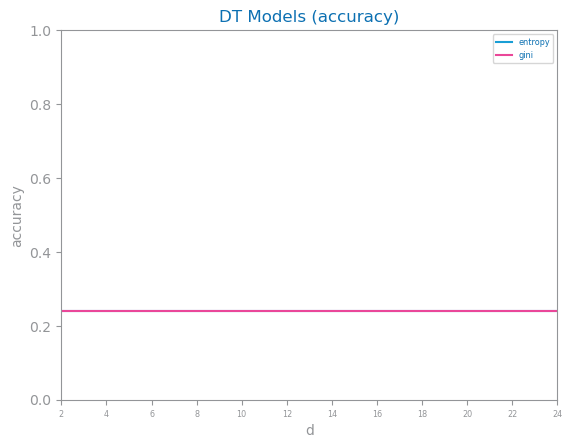

In [17]:
if evaluate==True:

    best_model_fl, fl_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='accuracy')
    savefig(f'images/{file_tag}_dt_accuracy_study.png')
    show()

## Evaluate for best model - Decision Trees

DT best with entropy and d=2


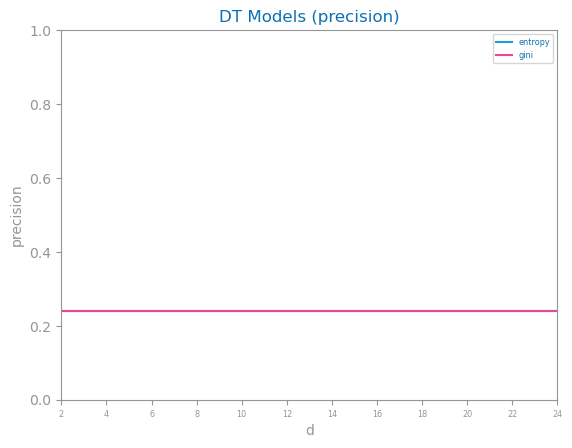

In [18]:
if evaluate==True:

    figure()

    eval_metric = 'precision'

    best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()

# Best Model Performance

<Figure size 640x480 with 0 Axes>

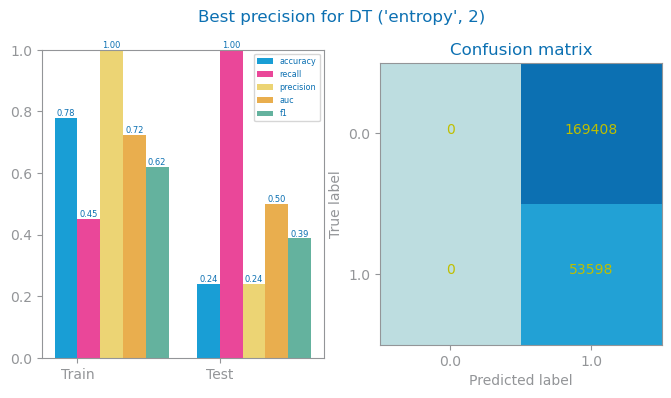

In [19]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

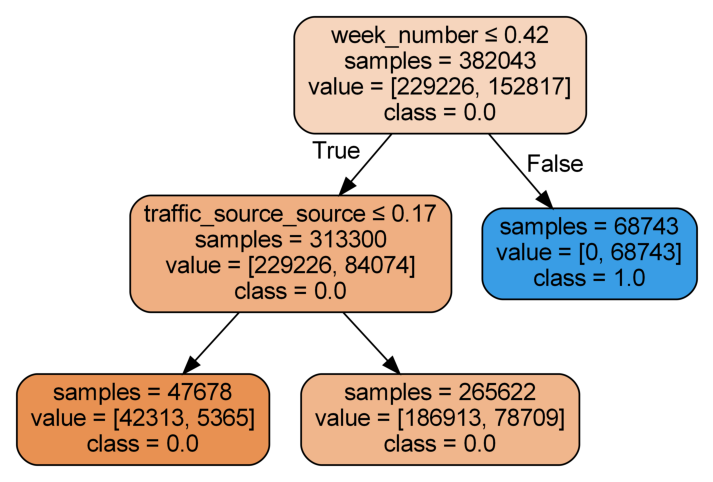

In [20]:
if evaluate==True:
    from sklearn.tree import export_graphviz
    from matplotlib.pyplot import imread, imshow, axis
    from subprocess import call

    tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
    max_depth2show = 8
    st_labels: list[str] = [str(value) for value in labels]

    dot_data: str = export_graphviz(
        best_model,
        out_file=tree_filename + ".dot",
        max_depth=max_depth2show,
        feature_names=vars,
        class_names=st_labels,
        filled=True,
        rounded=True,
        impurity=False,
        special_characters=True,
        precision=2,
    )
    # Convert to png
    call(
        ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
    )

    figure(figsize=(14, 6))
    imshow(imread(tree_filename + ".png"))
    axis("off")
    show()

## simpler tree

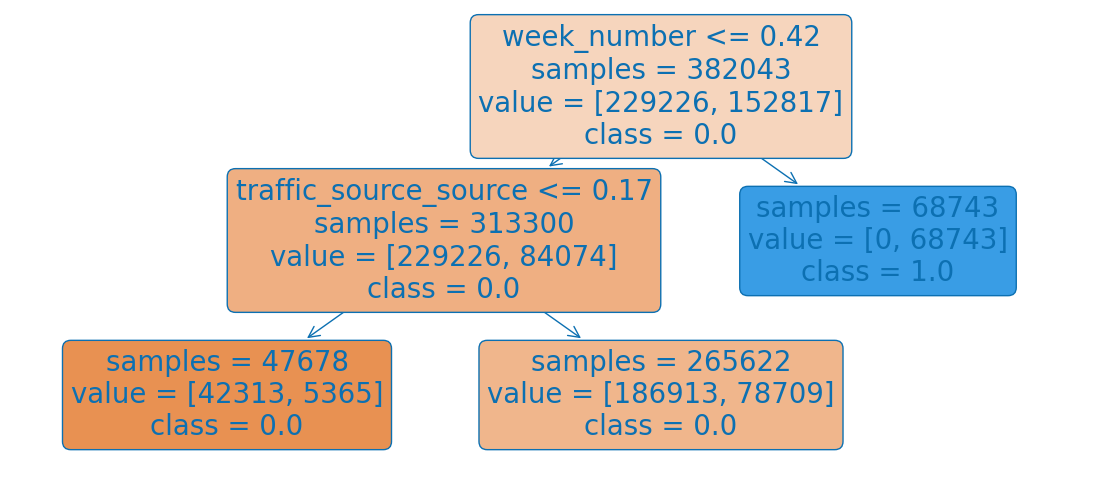

In [21]:
if evaluate==True:
    from sklearn.tree import plot_tree

    figure(figsize=(14, 6))
    plot_tree(
        best_model,
        max_depth=max_depth2show,
        feature_names=vars,
        class_names=st_labels,
        filled=True,
        rounded=True,
        impurity=False,
        precision=2,
    )
    savefig(tree_filename + "_simple.png")

    show()

# Feature Importances

1. week_number (0.9490010749613291)
2. traffic_source_source (0.050998925038670796)
3. domain (0.0)
4. traffic_source_medium (0.0)
5. page_path_level_2 (0.0)
6. page_path_level_1 (0.0)
7. day_of_year (0.0)
8. month (0.0)
9. engagement_time_msec (0.0)
10. geo_city (0.0)
11. path_length (0.0)
12. geo_region (0.0)
13. device_web_info_browser_version (0.0)
14. device_web_info_browser (0.0)
15. device_language (0.0)
16. device_operating_system_version (0.0)
17. device_operating_system (0.0)
18. device_mobile_model_name (0.0)
19. page_path_level_3 (0.0)
20. time_of_day_sin (0.0)
21. is_weekend (0.0)
22. day_of_week_nr_sin (0.0)
23. quarter (0.0)
24. year (0.0)
25. session_engaged (0.0)
26. geo_country (0.0)
27. week_of_month_nr_cos (0.0)
28. week_of_month_nr_sin (0.0)
29. day_of_week_nr_cos (0.0)
30. day_cos (0.0)
31. time_of_day_cos (0.0)
32. day_sin (0.0)
33. hour_minute_fraction_cos (0.0)
34. hour_minute_fraction_sin (0.0)
35. local_minute_cos (0.0)
36. local_minute_sin (0.0)
37. local_ho

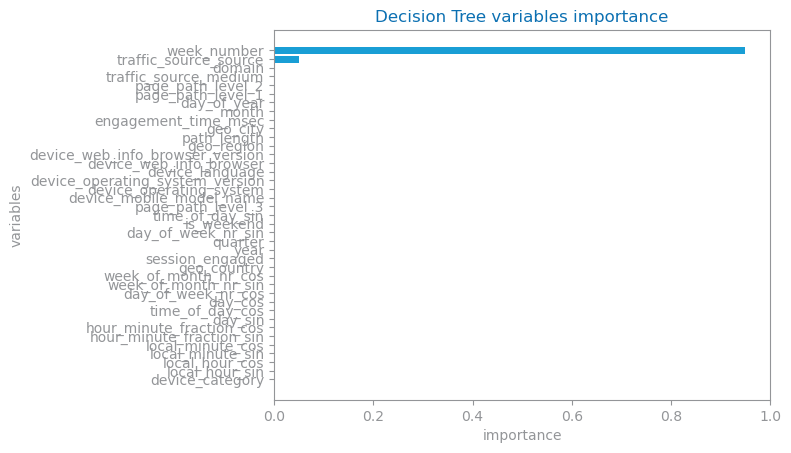

In [22]:
if evaluate==True:
    from numpy import argsort
    from dslabs_functions import plot_horizontal_bar_chart

    importances = best_model.feature_importances_
    indices: list[int] = argsort(importances)[::-1]
    elems: list[str] = []
    imp_values: list[float] = []
    for f in range(len(vars)):
        elems += [vars[indices[f]]]
        imp_values += [importances[indices[f]]]
        print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

    figure()
    plot_horizontal_bar_chart(
        elems,
        imp_values,
        title="Decision Tree variables importance",
        xlabel="importance",
        ylabel="variables",
        percentage=True,
    )
    savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")
    show()

# Overfitting

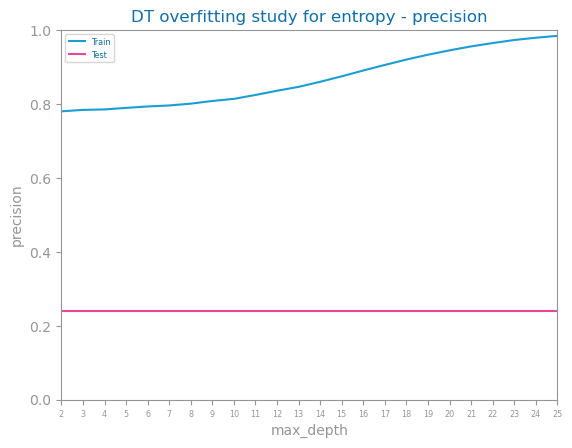

In [23]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit} - {eval_metric}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
